<a href="https://colab.research.google.com/github/rtegao/M5Forecasting/blob/master/ForecastingFood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Data Set

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Specialization/Projects/Recurrent Neural Networks/M5 - Data/sales_train_validation.csv')

In [0]:
dataset.shape

(30490, 1919)

In [0]:
dataset.head()

id        item_id  ... d_1912 d_1913
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  ...      1      1
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  ...      0      0
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  ...      1      1
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  ...      7      2
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  ...      2      4

[5 rows x 1919 columns]

In [0]:
dataset.loc[:,'d_1':].shape

(30490, 1913)

# In this Notebook I'll try to crate N LSTM models to predict a Food product from one store.


In [0]:
dataset.groupby(['state_id','cat_id']).first()

id  ... d_1913
state_id cat_id                                      ...       
CA       FOODS          FOODS_1_001_CA_1_validation  ...      0
         HOBBIES      HOBBIES_1_001_CA_1_validation  ...      1
         HOUSEHOLD  HOUSEHOLD_1_001_CA_1_validation  ...      1
TX       FOODS          FOODS_1_001_TX_1_validation  ...      0
         HOBBIES      HOBBIES_1_001_TX_1_validation  ...      2
         HOUSEHOLD  HOUSEHOLD_1_001_TX_1_validation  ...      0
WI       FOODS          FOODS_1_001_WI_1_validation  ...      1
         HOBBIES      HOBBIES_1_001_WI_1_validation  ...      1
         HOUSEHOLD  HOUSEHOLD_1_001_WI_1_validation  ...      0

[9 rows x 1917 columns]

In [0]:
group = dataset.groupby(['state_id','cat_id']).first()
df_food =  group.loc[('WI','FOODS'),'d_1':]
del group

# Spliting Data

In [0]:
train_limit = int(round((df_food.shape[0])*0.7,0))
val_limit = int(round((df_food.shape[0])*0.85,0))

df_food_train = df_food[:train_limit]
df_food_val = df_food[train_limit:val_limit]
df_food_test = df_food[val_limit:]

print(df_food_test.shape)

(287,)


# Normalizing Data


In [0]:
df_food_train = df_food_train.values.reshape(-1,1)
df_food_val = df_food_val.values.reshape(-1,1)
df_food_test = df_food_test.values.reshape(-1,1)

print(df_food_train.shape)
print(df_food_val.shape)
print(df_food_test.shape)

(1339, 1)
(287, 1)
(287, 1)


In [0]:
scaler_food = MinMaxScaler(feature_range=(0,1))
df_food_train = scaler_food.fit_transform(df_food_train)
df_food_val = scaler_food.transform(df_food_val)
df_food_test = scaler_food.transform(df_food_test)

# Regressor

- # The competition determines that the model predict 28 days in the future, so we need to scale the regressor and the outputs for this prerequisite.

- # The step time for each LTMS can be different, so lets start with the Hobbies data



In [0]:
def Regressor(future_steps,time_steps,n_features,df_train,df_val,df_test):
  # future_steps: how many days in the furure to predict 
  # time_steps: number of samples the LSTM model will use for predict 28 days in the future
  # n_features: number of features (LSTM input) 

  #################### TRAIN #################################################
  # Defining the number of samples for the train data
  n_samples = df_train.shape[0]
  x_train = []
  y_train = []

  # shaping data to have the number of time_steps in the x_train ans the 28 future values in the y_train 
  for i in range(time_steps,n_samples - time_steps): 
    x_train.append(df_train[i - time_steps : i, 0])
    y_train.append(df_train[i : i+future_steps,0])

  x_train,y_train = np.array(x_train),np.array(y_train) # transforming in array
  # LSTM need 3D tensor as input 
  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],n_features))  

  ##################### VALIDATION ###############################################

  # to predict the first 28 values of the validation data, LSTM need time_steps values. 
  # to make this possible I'm using the last 60 values that came before the validation data.
  df_val = np.concatenate((df_train[-time_steps:],df_val))

  n_samples = df_val.shape[0]
  x_val = []
  y_val = []

  for i in range(time_steps,n_samples - time_steps):
    x_val.append(df_val[i - time_steps : i, 0])
    y_val.append(df_val[i : i+future_steps,0])

  x_val,y_val = np.array(x_val),np.array(y_val)
  x_val = np.reshape(x_val,(x_val.shape[0],x_val.shape[1],n_features))

  ####################### TEST ################################################
  # the same methodologie implemented in training and validation data are here in the test data

  df_test = np.concatenate((df_val[-time_steps:],df_test))
  n_samples = df_test.shape[0]
  x_test = []
  y_test = []

  for i in range(time_steps,n_samples - time_steps):
    x_test.append(df_test[i - time_steps : i, 0])
    y_test.append(df_test[i : i+future_steps,0])

  x_test,y_test = np.array(x_test),np.array(y_test)
  x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],n_features))
  
  return x_train,x_test,x_val,y_train,y_val,y_test

In [0]:
time_steps = 60
future_steps = 28
n_features = 1
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_food_train,df_val = df_food_val,df_test = df_food_test)

# LSTM (Hobbies)

## First try

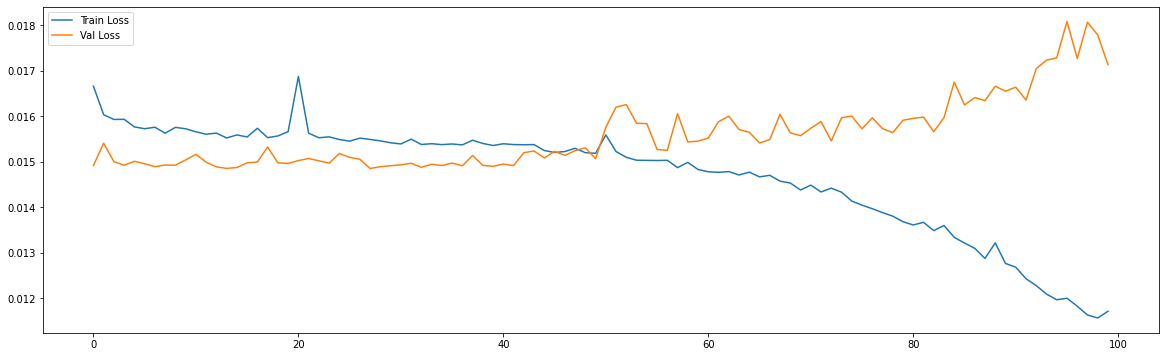

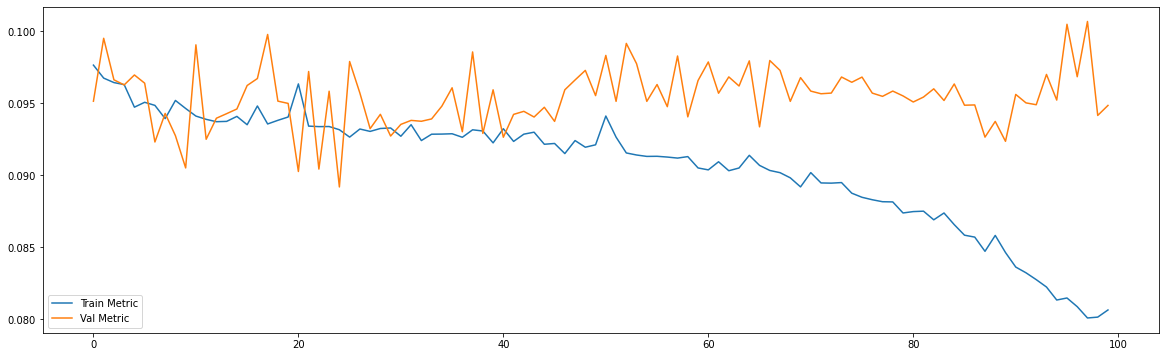

In [0]:
# The LSTM architecture

regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) # return_sequences=False next layer is not LSTM
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

### Predict

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

### Plot

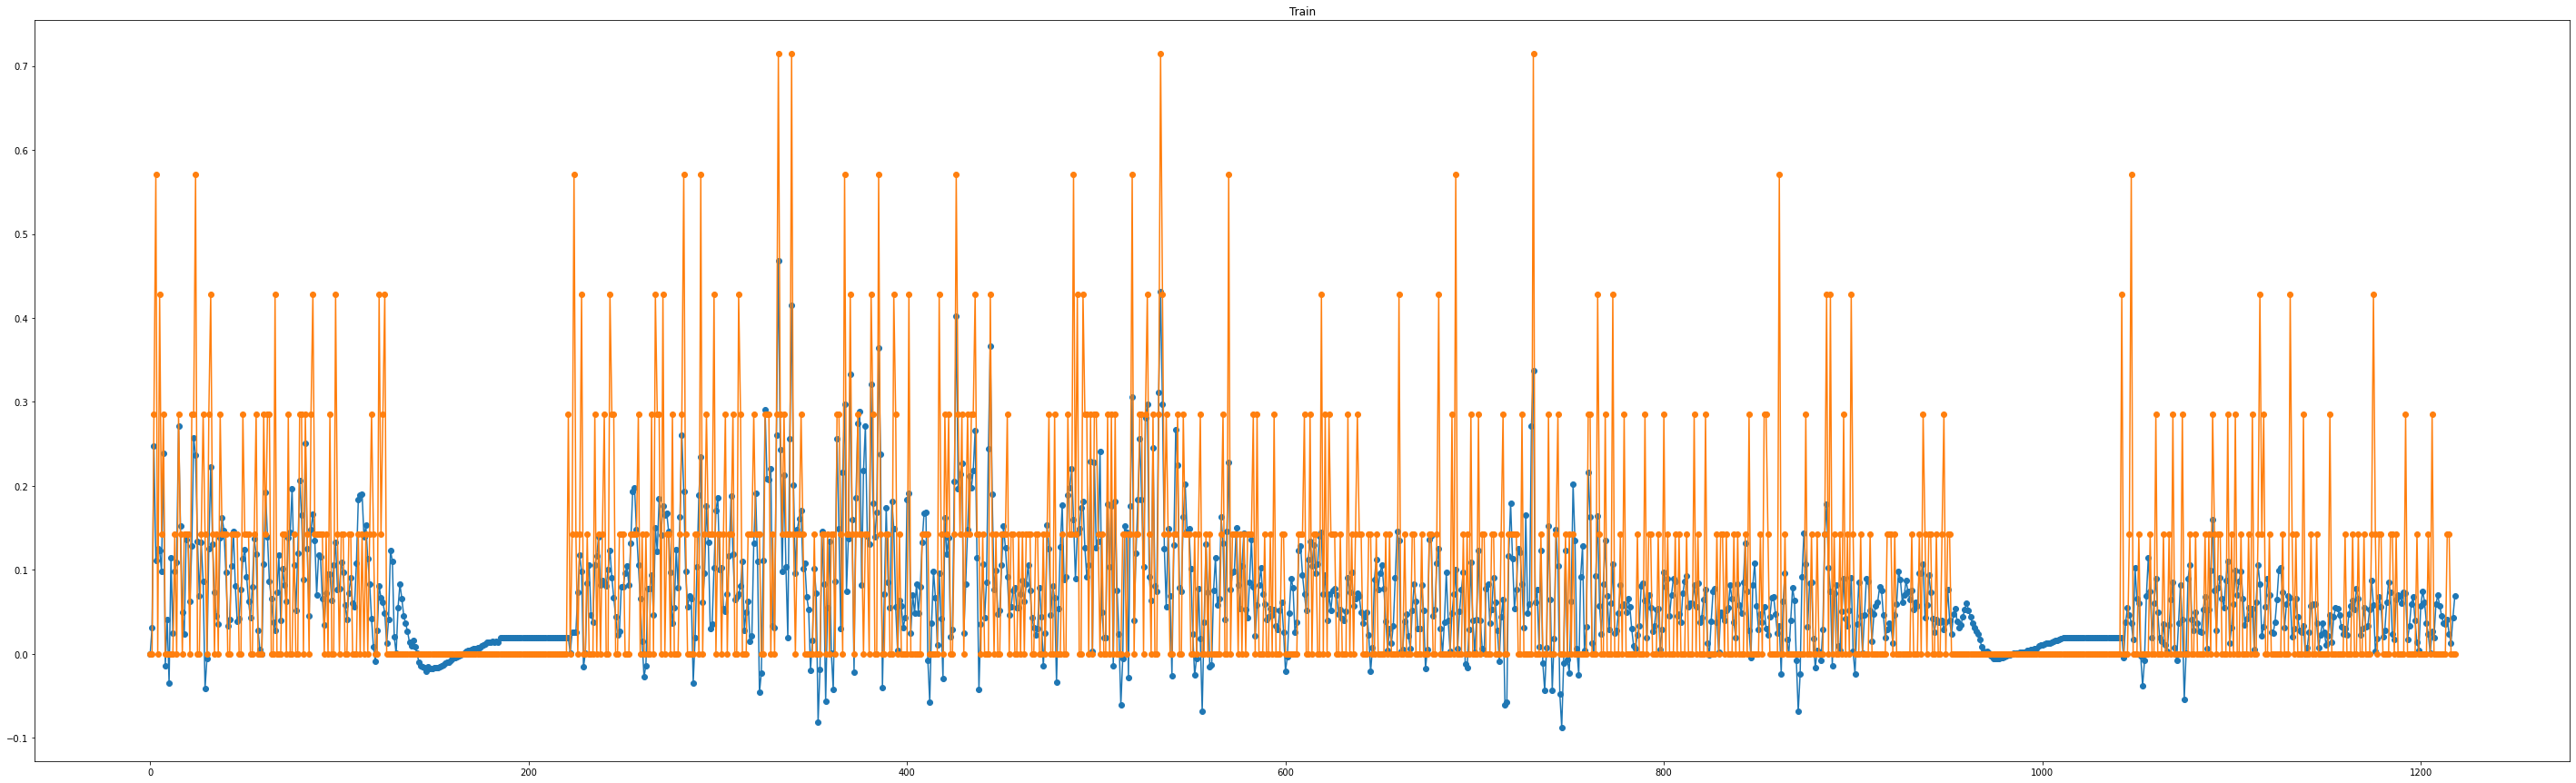

In [0]:
plt.figure(figsize=(50,15))
plt.plot(y_train_predict[:,0],marker='o')
plt.plot(y_train[:,0],marker='o')
plt.title('Train')
plt.show()

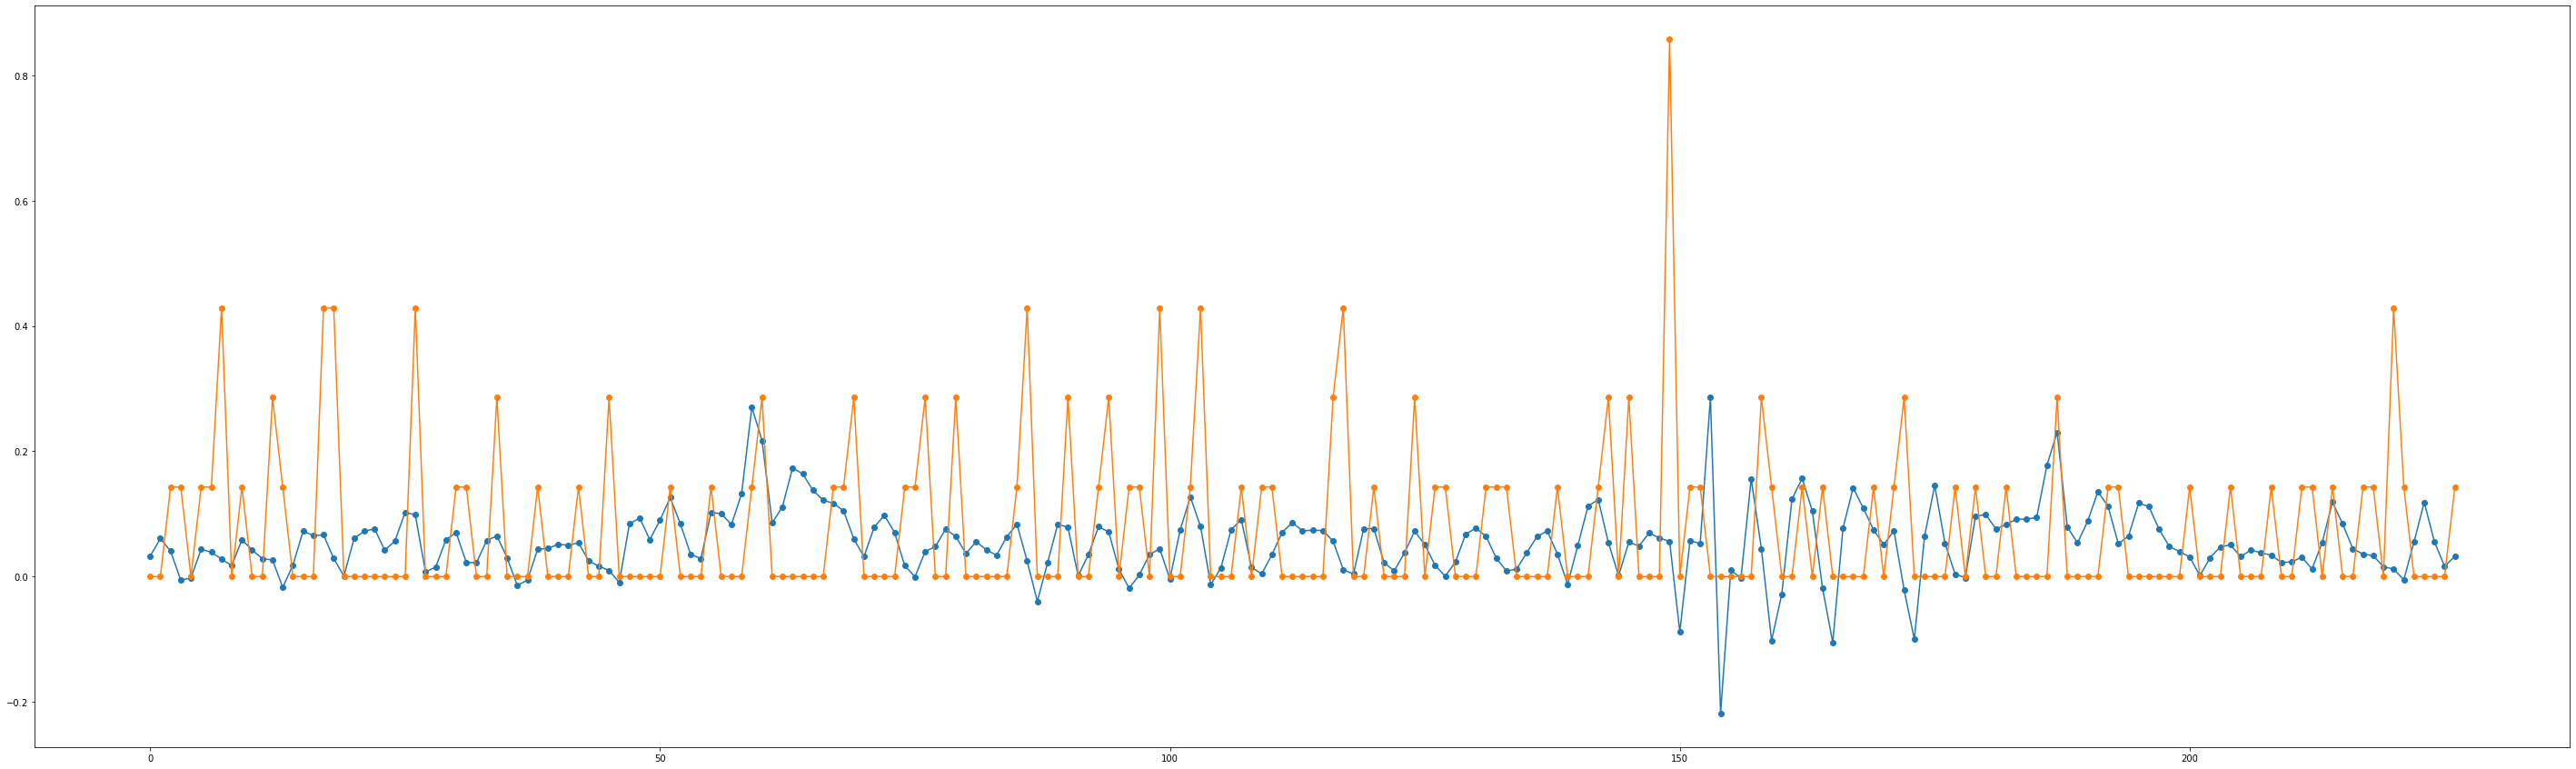

In [0]:
plt.figure(figsize=(50,15))
plt.plot(y_val_predict[:,0],marker='o')
plt.plot(y_val[:,0],marker='o')

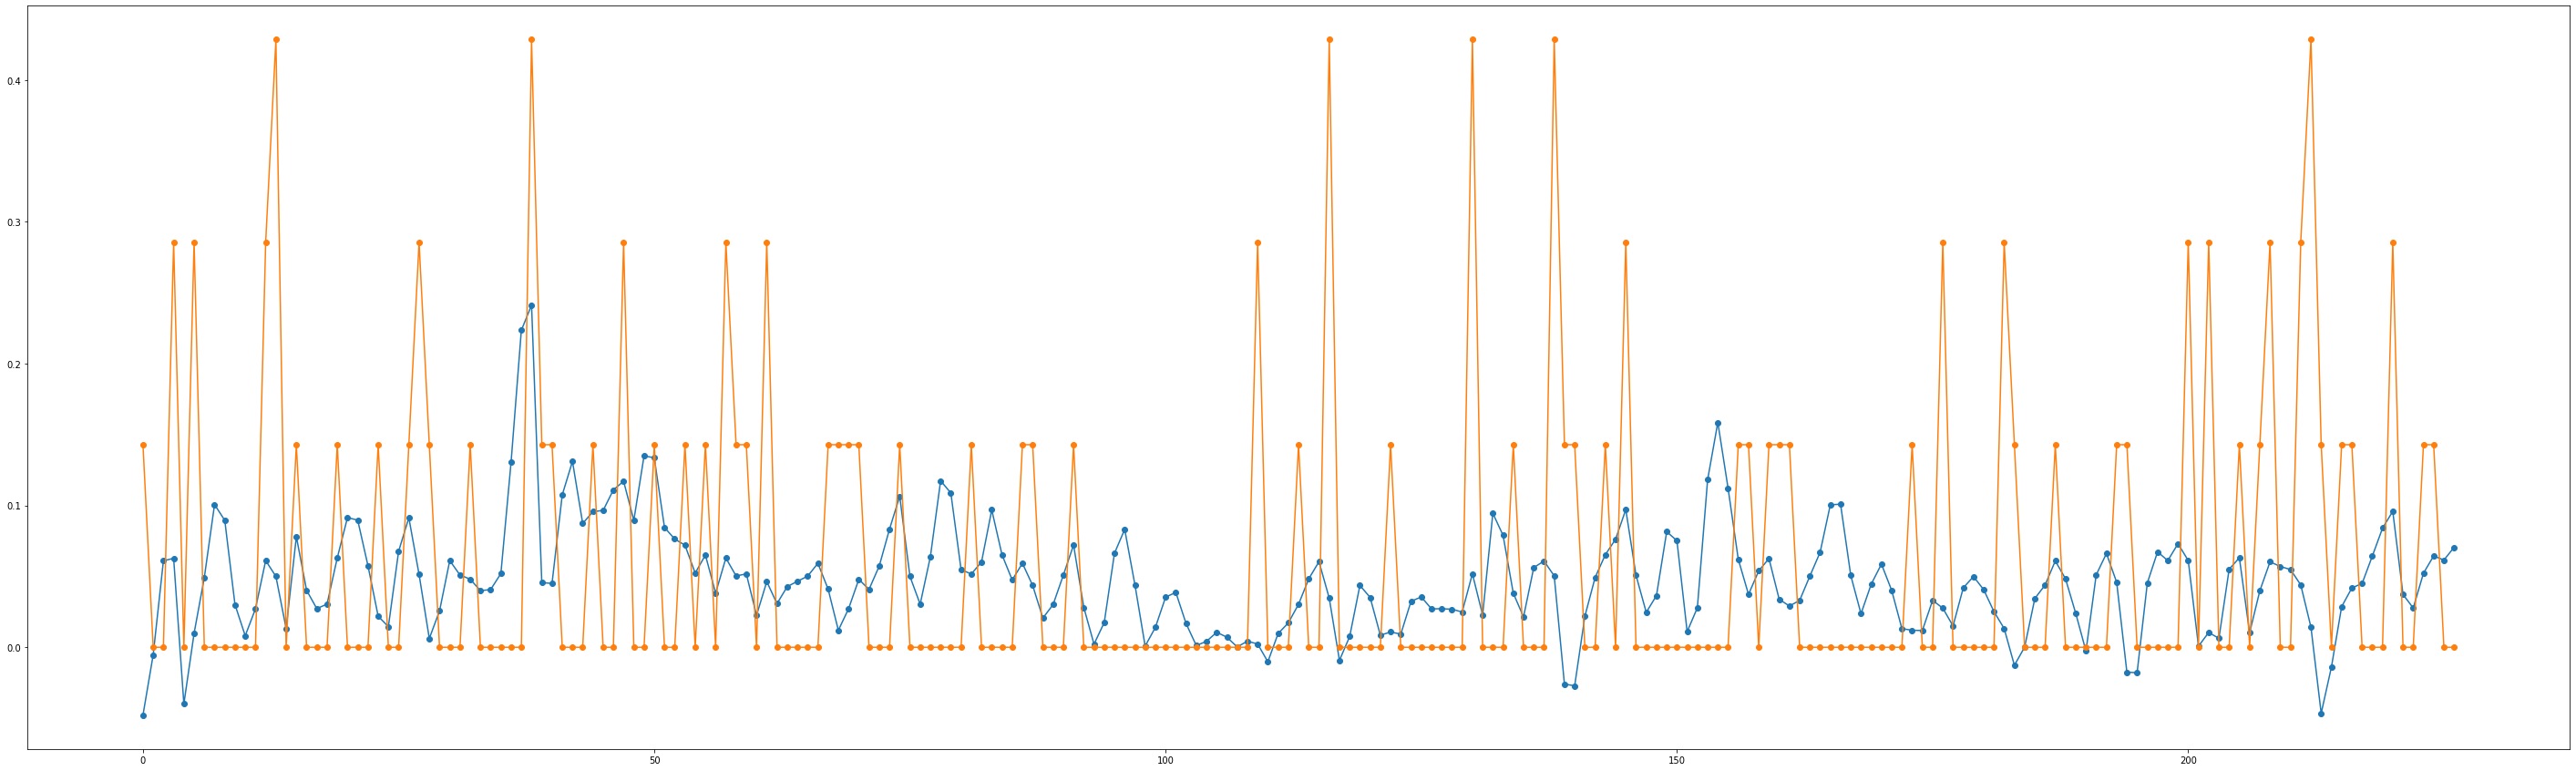

In [0]:
plt.figure(figsize=(50,15))
plt.plot(y_test_predict[:,0],marker='o')
plt.plot(y_test[:,0],marker='o')

## Dropout

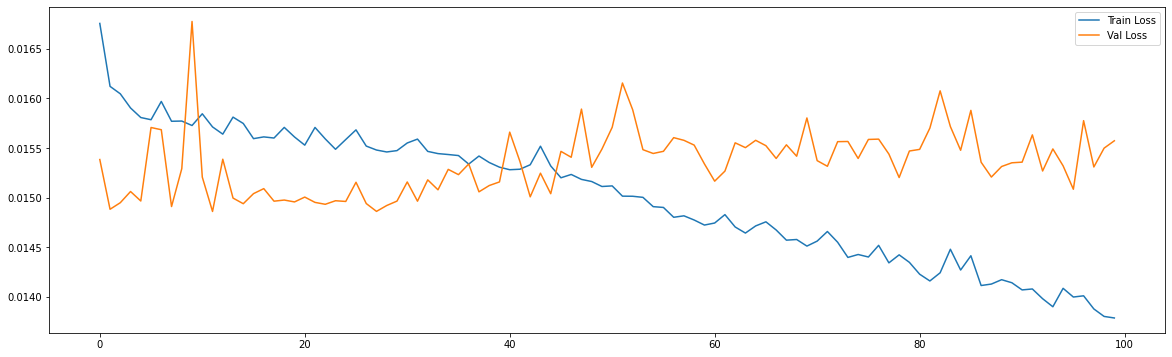

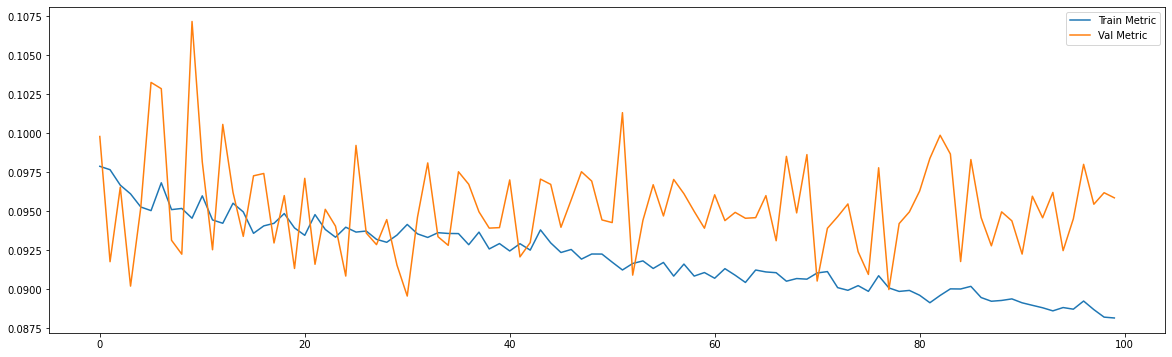

In [0]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

### Predicting Data

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

### Plot

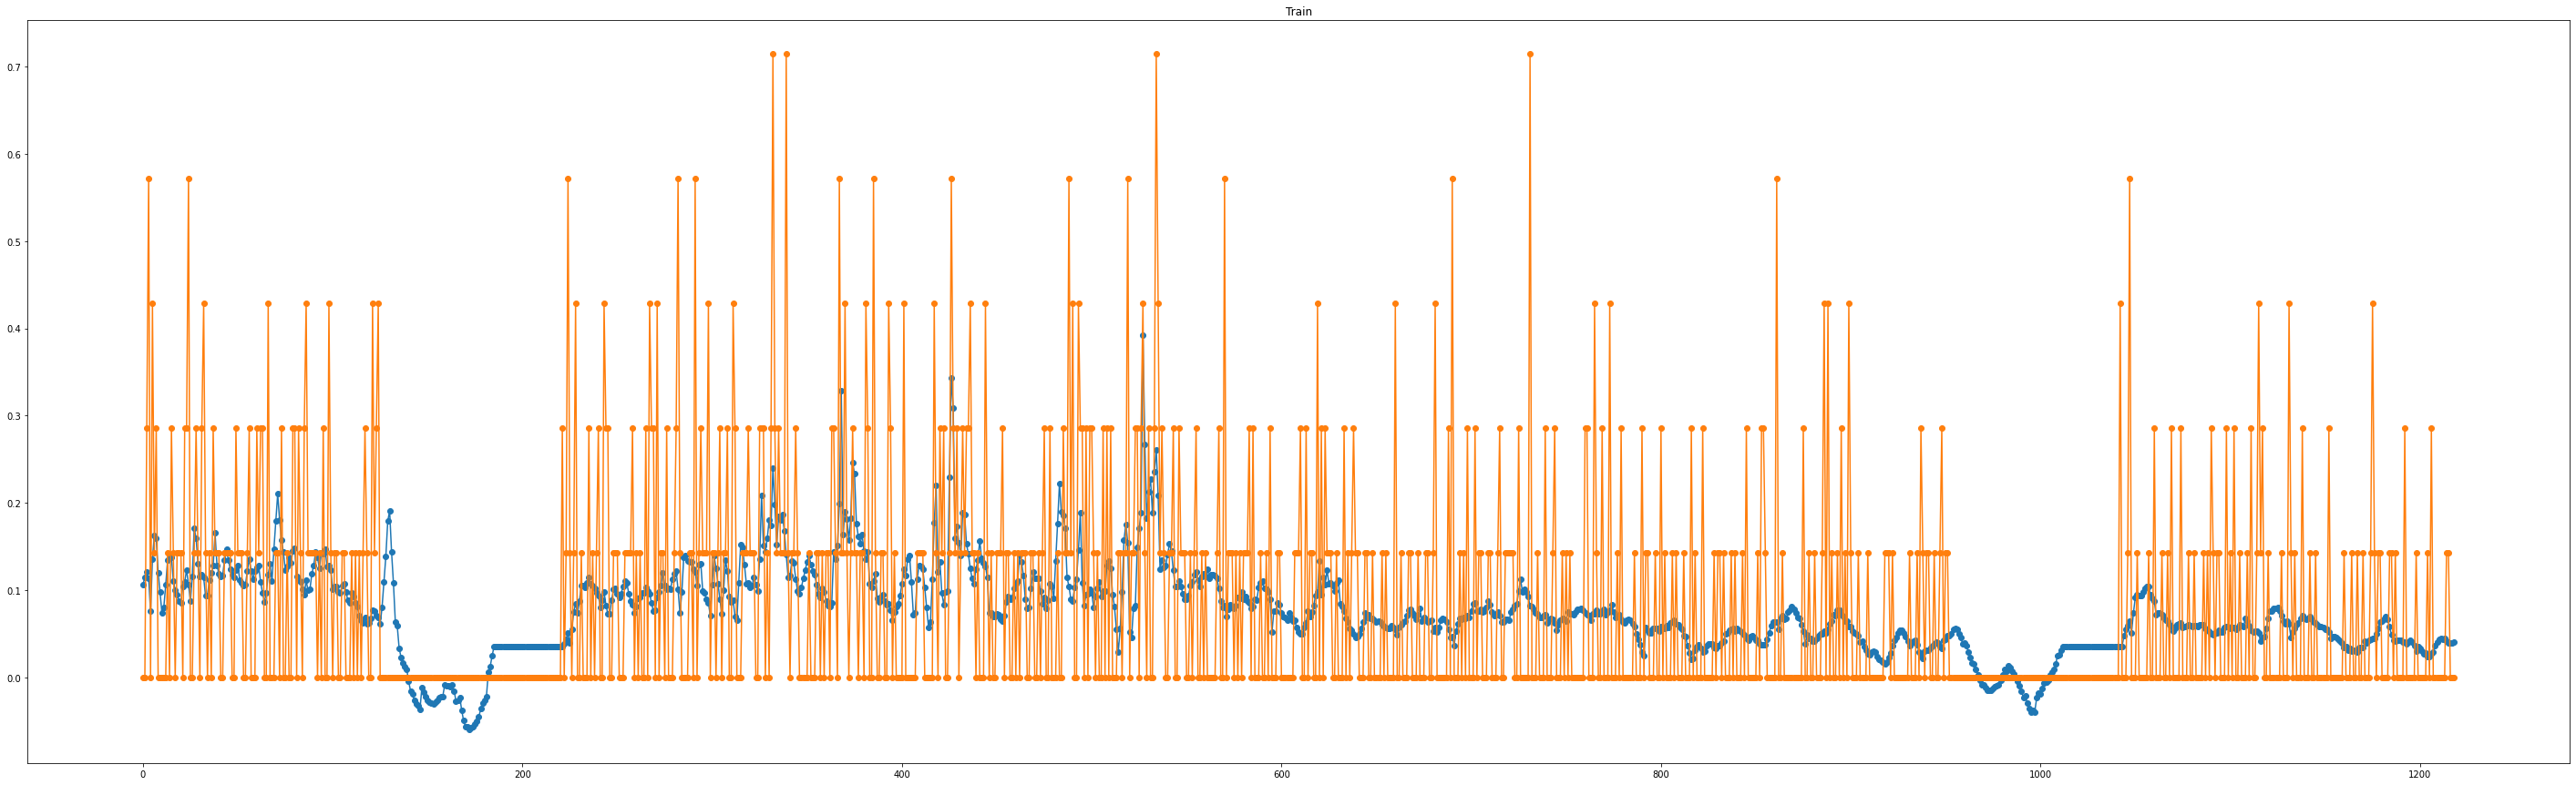

In [0]:
plt.figure(figsize=(50,15))
plt.plot(y_train_predict[:,0],marker='o')
plt.plot(y_train[:,0],marker='o')
plt.title('Train')
plt.show()

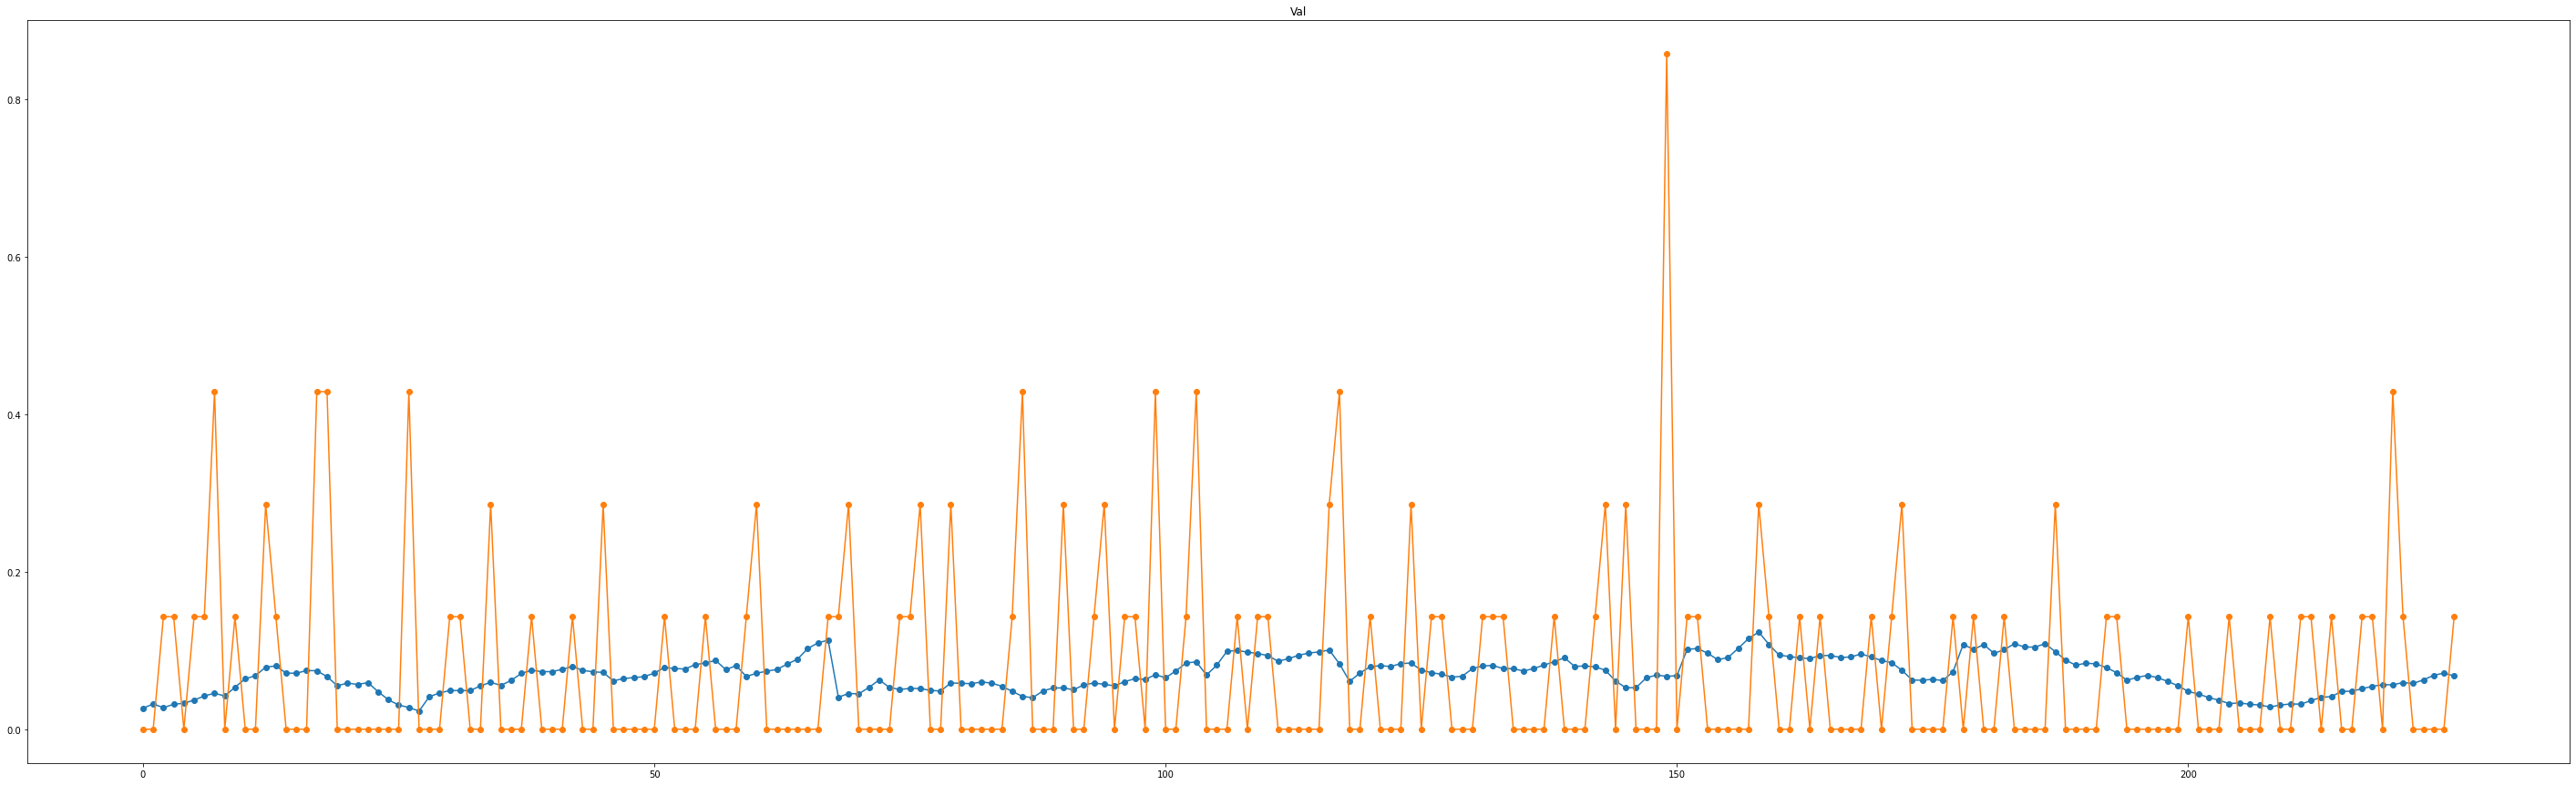

In [0]:
plt.figure(figsize=(50,15))
plt.plot(y_val_predict[:,0],marker='o')
plt.plot(y_val[:,0],marker='o')
plt.title('Val')
plt.show()

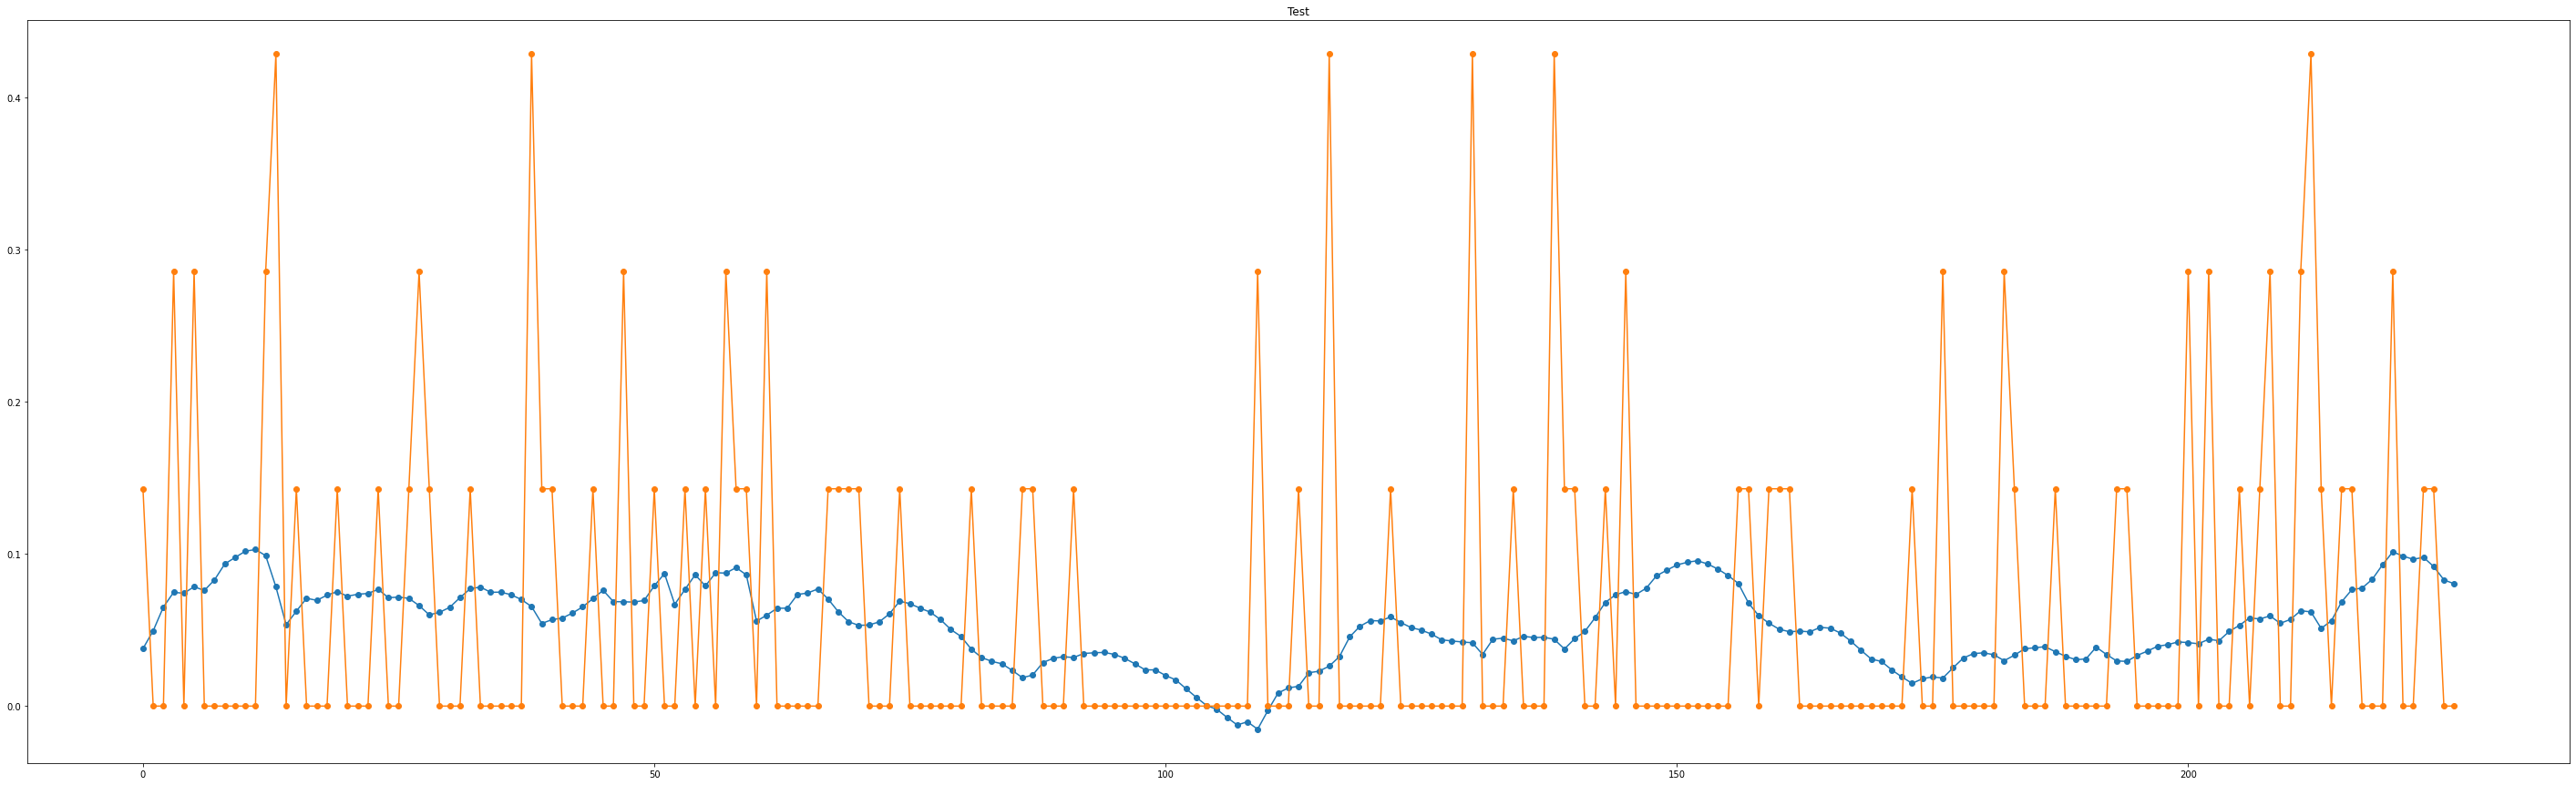

In [0]:
plt.figure(figsize=(50,15))
plt.plot(y_test_predict[:,0],marker='o')
plt.plot(y_test[:,0],marker='o')
plt.title('Test')
plt.show()

## Dropout with L2 regularization 

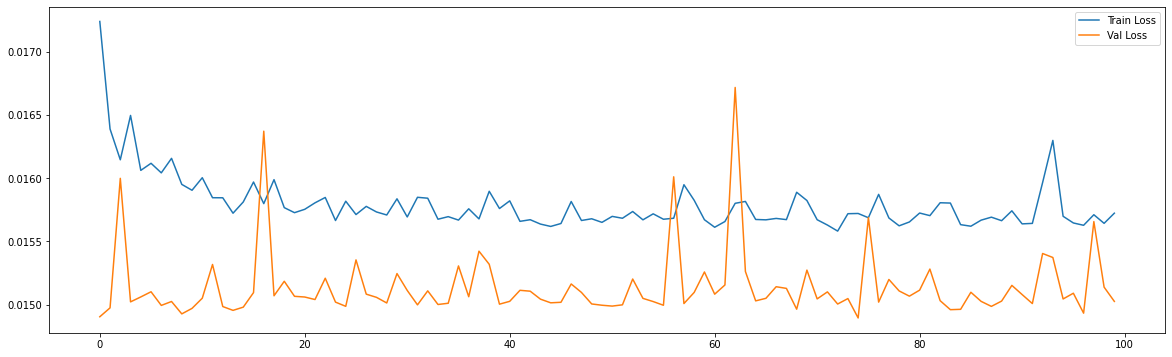

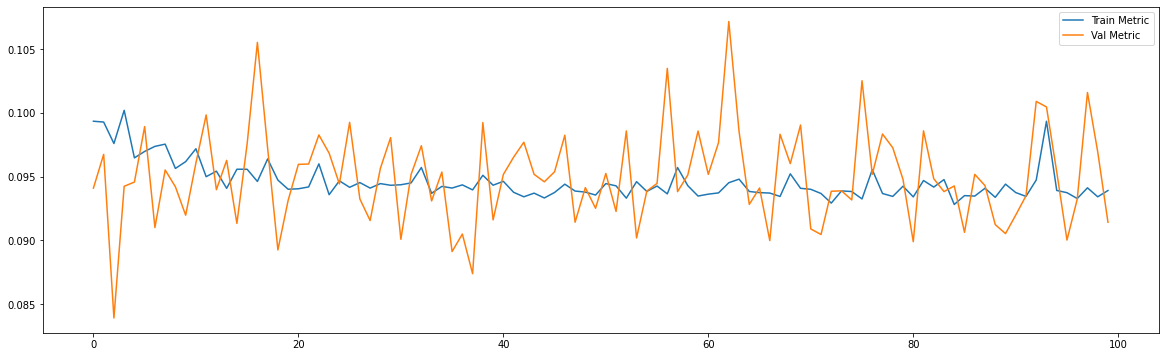

In [0]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, kernel_regularizer = regularizers.l2(0.001),input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 100, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Decreasing the learning rate and increasing the number of epochs

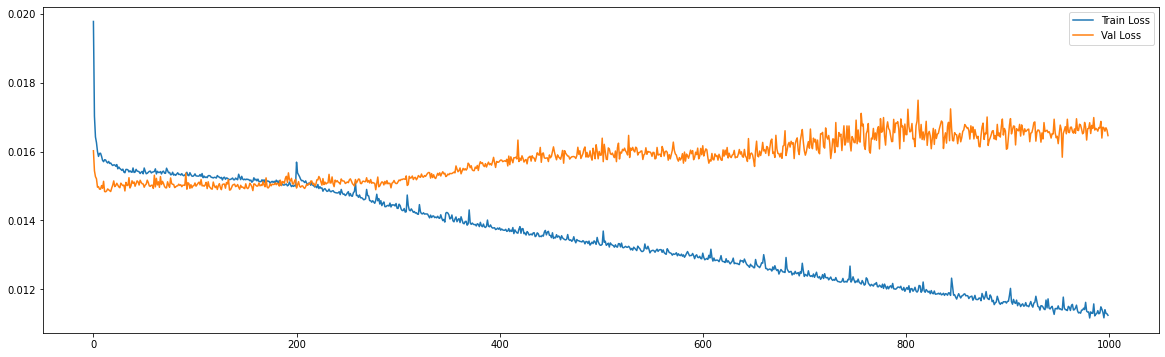

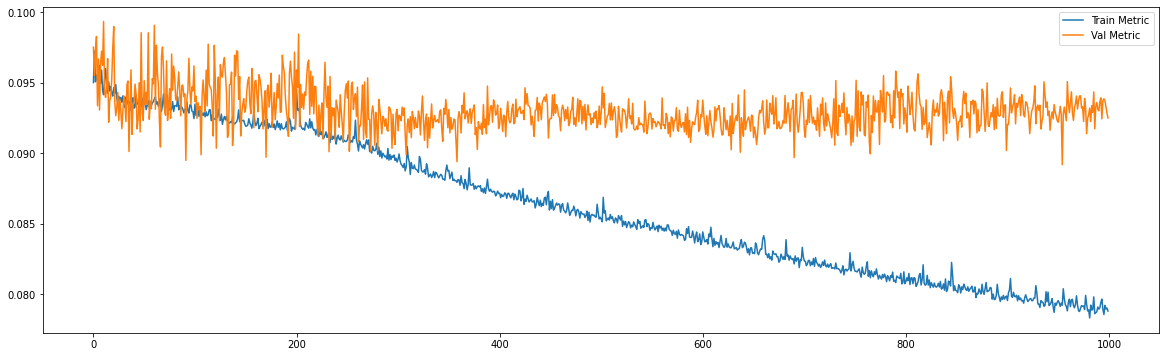

In [0]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, kernel_regularizer = regularizers.l2(0.001),input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 1000, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Increasing L2 regularization

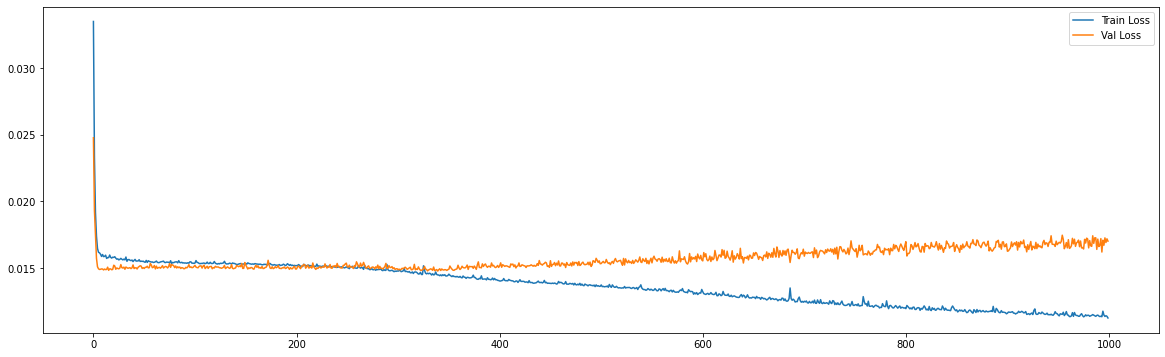

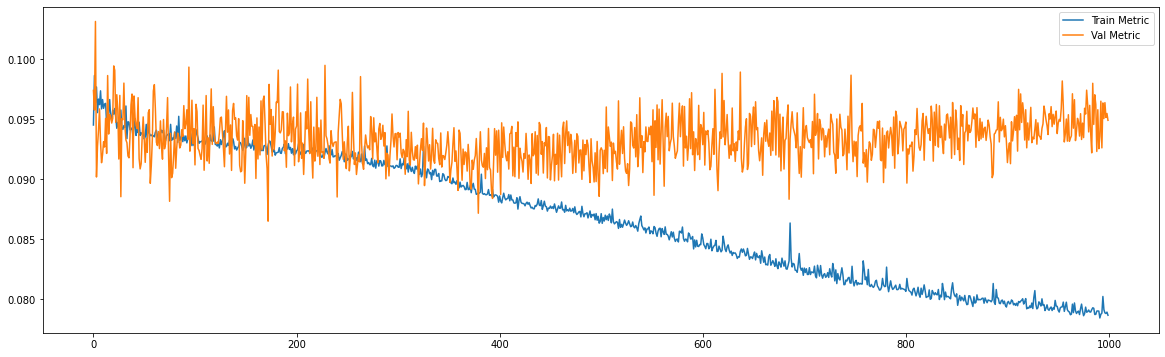

In [0]:
# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, kernel_regularizer = regularizers.l2(0.01),input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 1000, batch_size=32, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Decreasing number of neurons with dropout

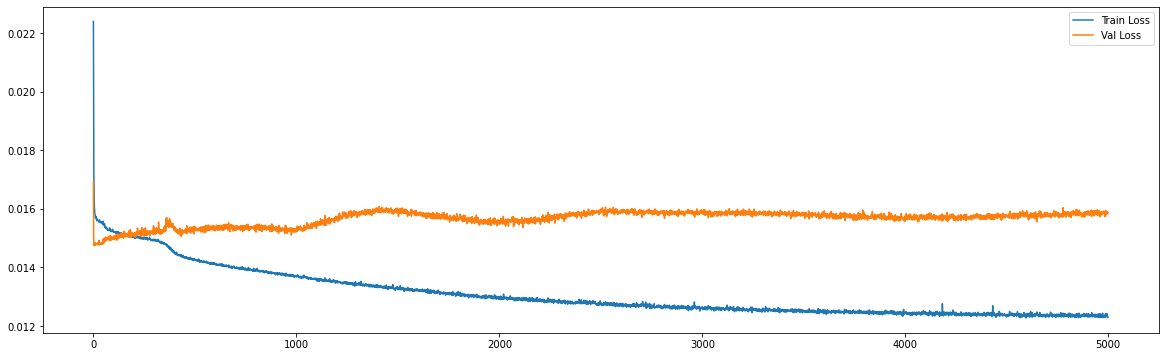

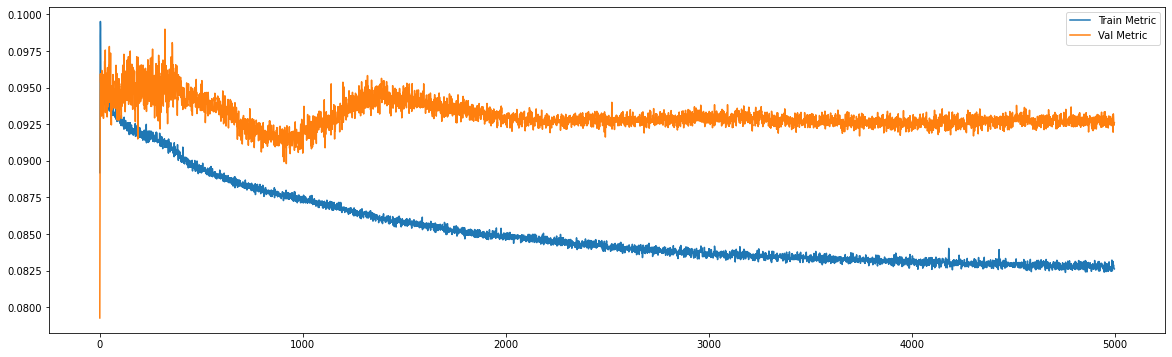

In [0]:
 # The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=20, return_sequences=False,input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 5000, batch_size=60, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Less Neurons with bigger dropout

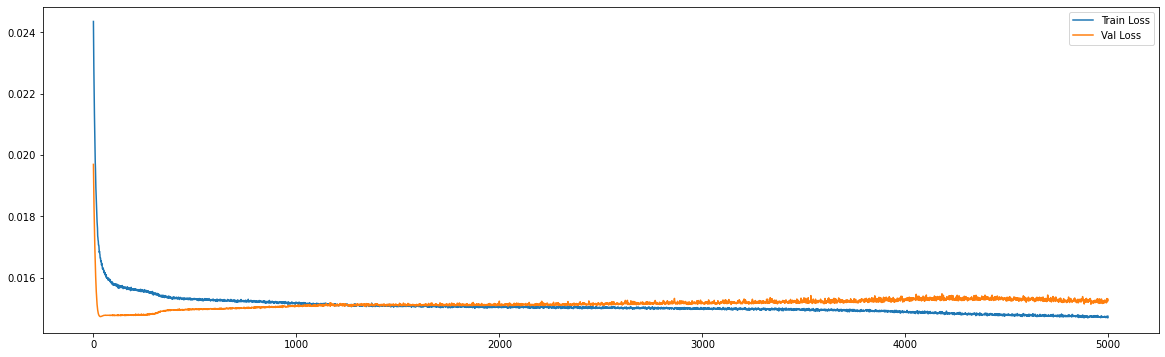

In [0]:
 # The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=20, return_sequences=False, input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.4))
regressor.add(Dense(units=28))

#Compiling the LSTM
adam = optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 5000, batch_size=60, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

## Last chance... I'll use the best model until now and change the time steps and the batch size. 

============================model:0===========================


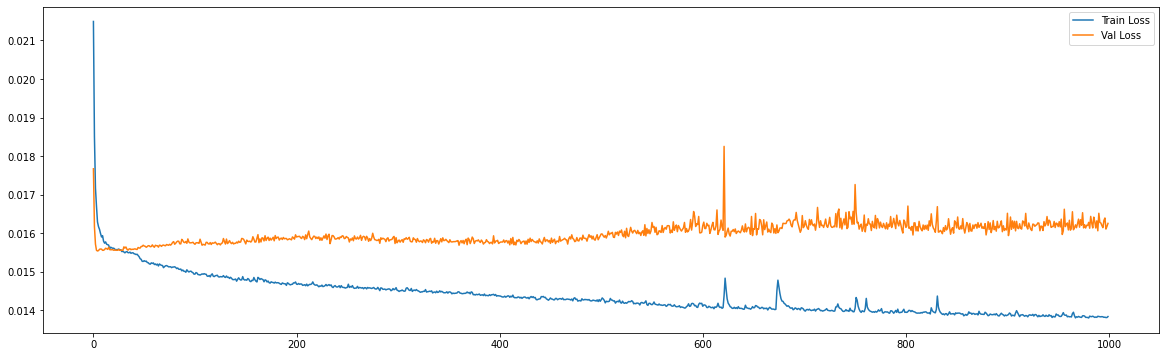

============================model:1===========================


============================model:2===========================


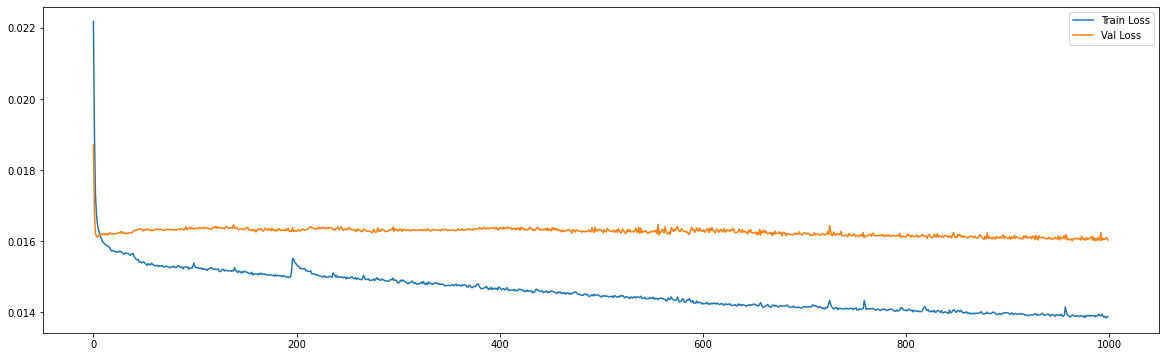

============================model:3===========================


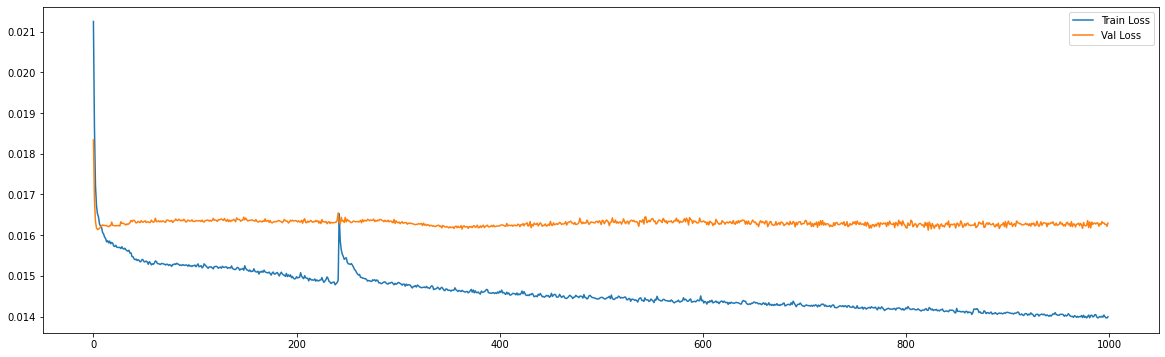

In [0]:
future_steps = 28
n_features = 1

time_steps_list = [84,100]
bach_list = [84,100]
models = {}
i=0
for time_steps in time_steps_list:
  for batch in bach_list:
    x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_food_train,df_val = df_food_val,df_test = df_food_test)

    models[i] = {'time_steps': time_steps, 'batch_size':batch}
    models[i]['resumo'] = "'time_steps': {}, 'batch_size':{}".format(time_steps,batch)

    # The LSTM architecture
    models[i] = Sequential()
    models[i].add(LSTM(units=20, return_sequences=False,input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
    models[i].add(Dropout(0.25))
    models[i].add(Dense(units=28))

    #Compiling the LSTM
    adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
    models[i].compile(optimizer = adam, loss = 'mse', metrics=['mae'])

    #Fitting to traning set
    history = models[i].fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 1000, batch_size=batch, verbose = 0)

    print('============================model:{}==========================='.format(i))
    plt.figure(figsize=(20,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Train Loss', 'Val Loss'])

    plt.figure(figsize=(20,6))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.legend(['Train Metric', 'Val Metric'])
    plt.show()

    i+=1

# Changing pre-processing

In the attempts above, doesn't matter how much I increase the regularization 
methods the network doesn't generalise.

---

Now I'll try to make an outlier treatment to improve generalization. 

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Specialization/Projects/Recurrent Neural Networks/M5 - Data/sales_train_validation.csv')

In [0]:
group = dataset.groupby(['state_id','cat_id']).first()
df_food =  group.loc[('WI','FOODS'),'d_1':]
del group

train_limit = int(round((df_food.shape[0])*0.7,0))
val_limit = int(round((df_food.shape[0])*0.85,0))

df_food_train = df_food[:train_limit]
df_food_val = df_food[train_limit:val_limit]
df_food_test = df_food[val_limit:]

print(df_food_test.shape)

(287,)


## To detect outliers lets see the quantiles of 0.8, 0.9 and 0.95 

--- 

The values doesn't fluctuate to much at the distibution, let's impose a maximum value of 2.

In [0]:
print(df_food_train.quantile(q = 0.8))
print(df_food_train.quantile(q = 0.9))
print(df_food_train.quantile(q = 0.95))

1.0
2.0
2.0


## Normalizing

In [0]:
df_food_train = df_food_train.values.reshape(-1,1)
df_food_val = df_food_val.values.reshape(-1,1)
df_food_test = df_food_test.values.reshape(-1,1)

scaler_food = MinMaxScaler(feature_range=(0,1))
df_food_train = scaler_food.fit_transform(df_food_train)
df_food_val = scaler_food.transform(df_food_val)
df_food_test = scaler_food.transform(df_food_test)

## Regressor

============================model:0===========================


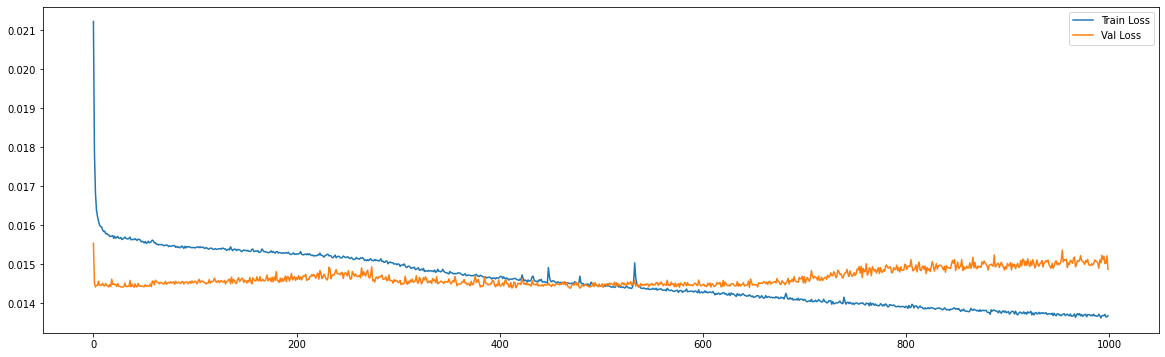

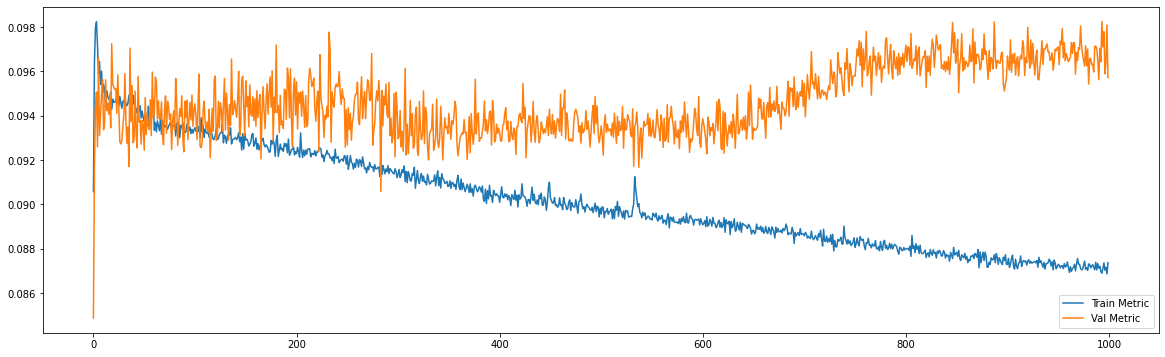

============================model:1===========================


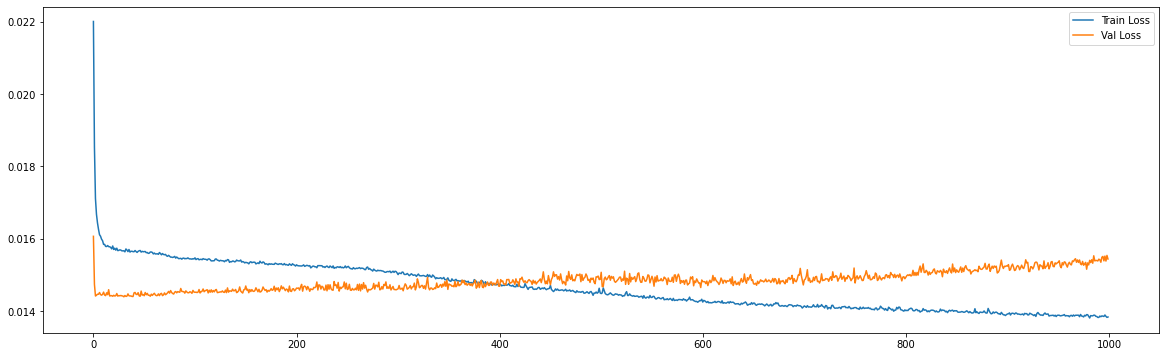

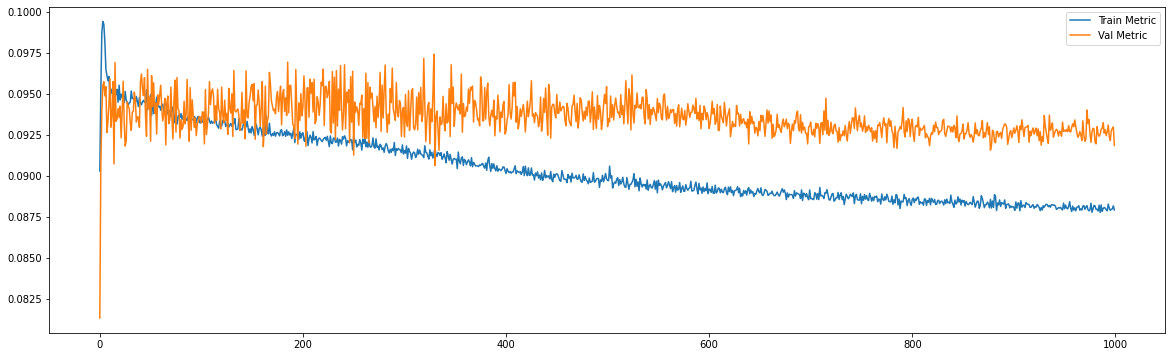

============================model:2===========================


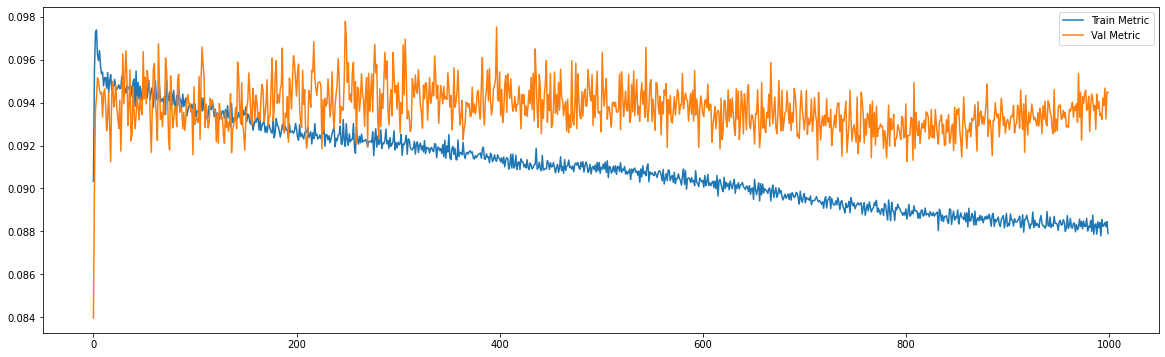

============================model:3===========================


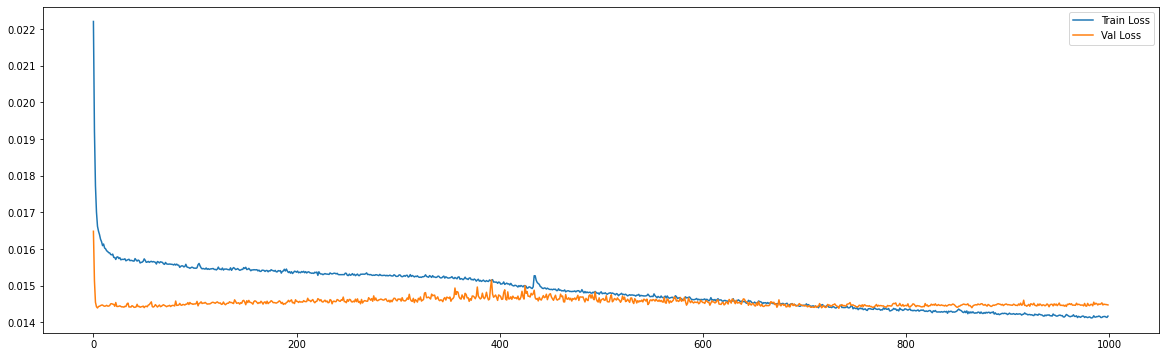

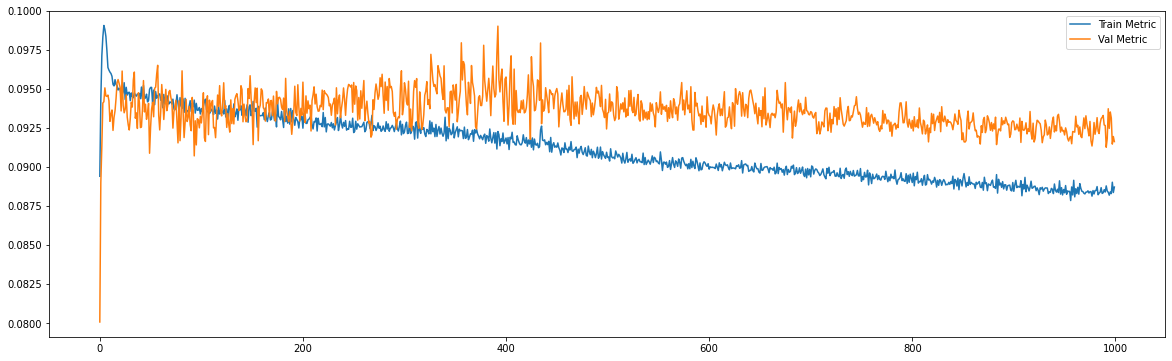

============================model:4===========================


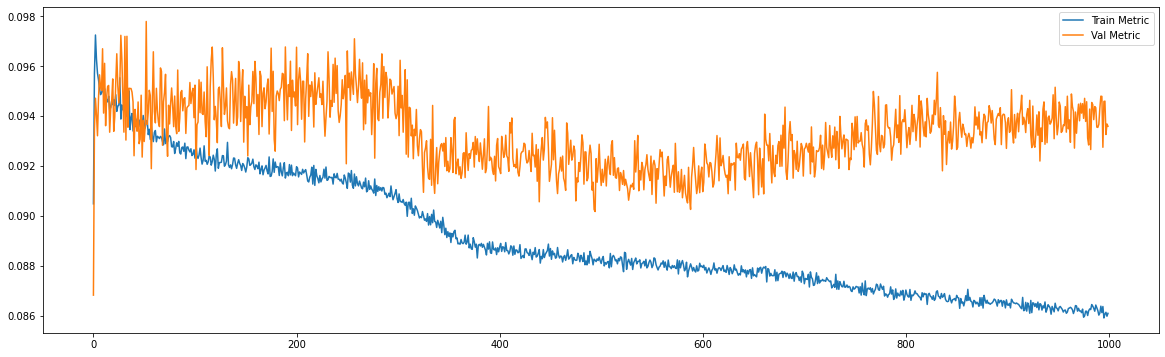

============================model:5===========================


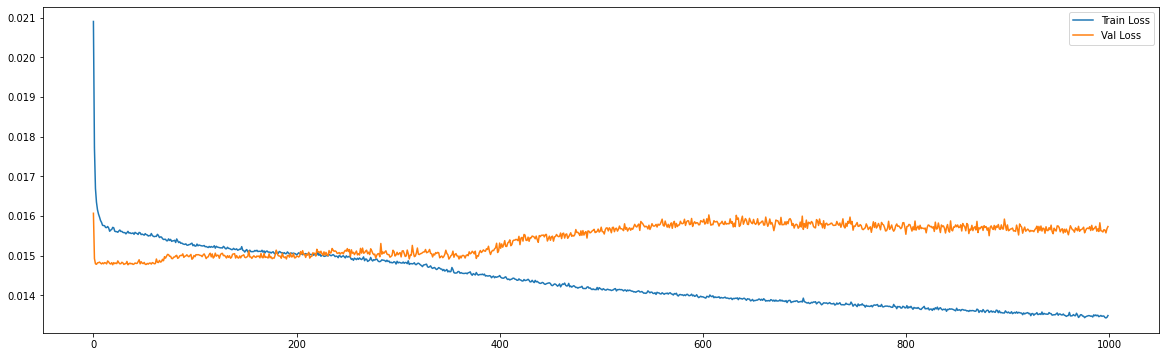

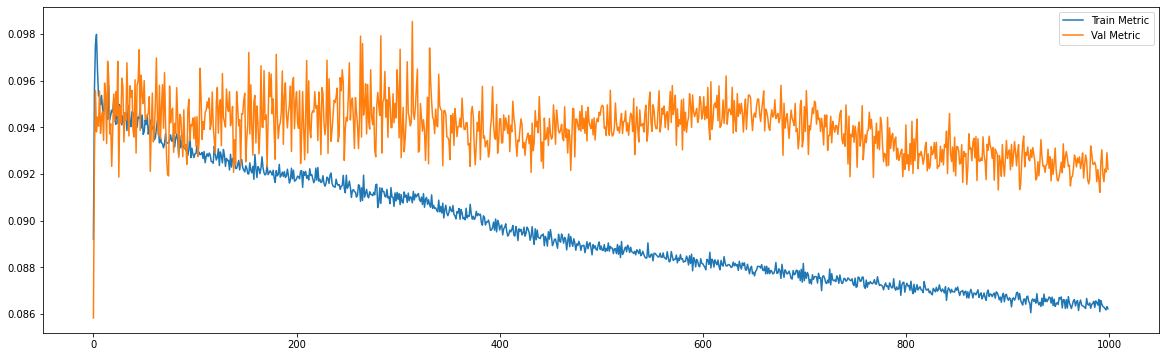

============================model:6===========================


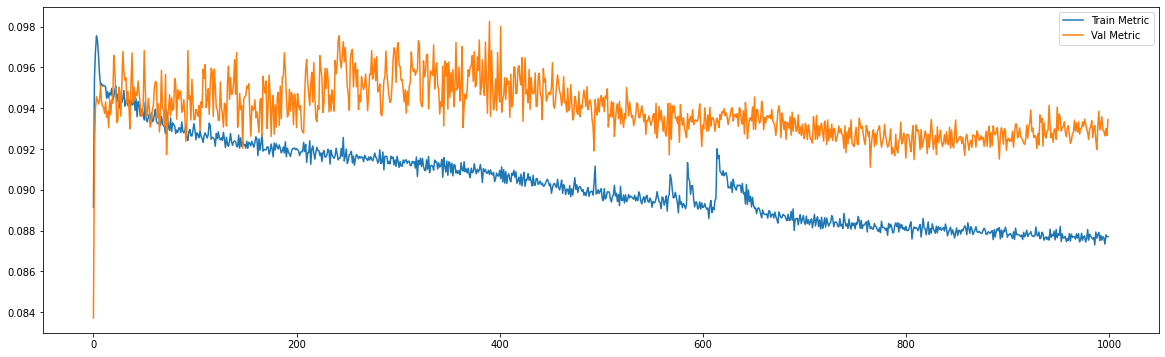

============================model:7===========================


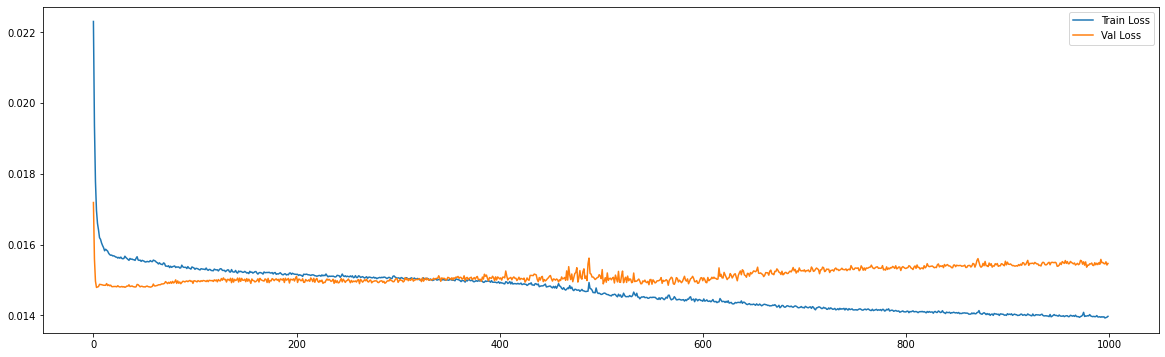

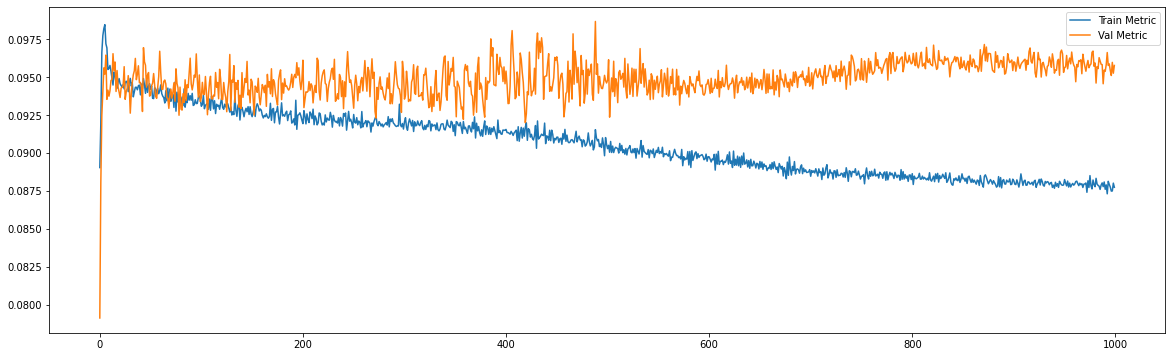

============================model:8===========================


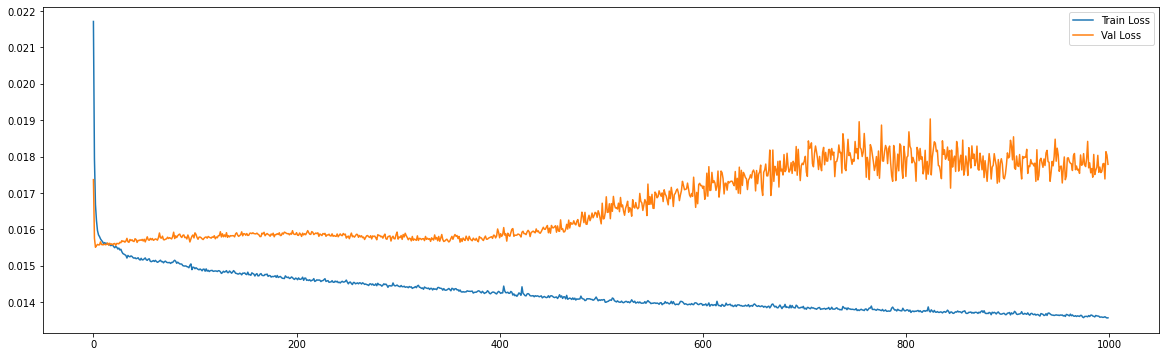

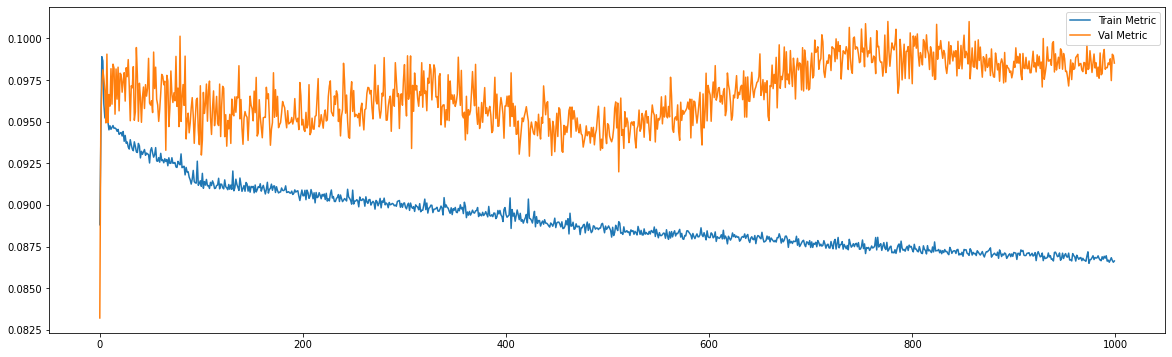

============================model:9===========================


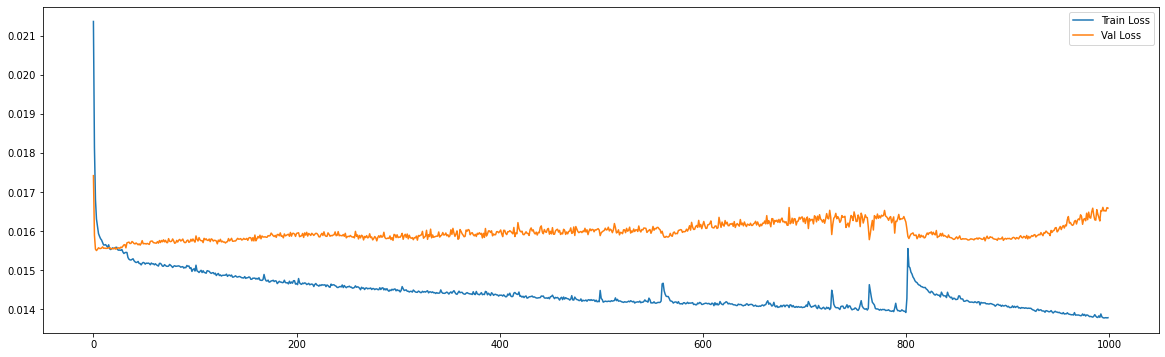

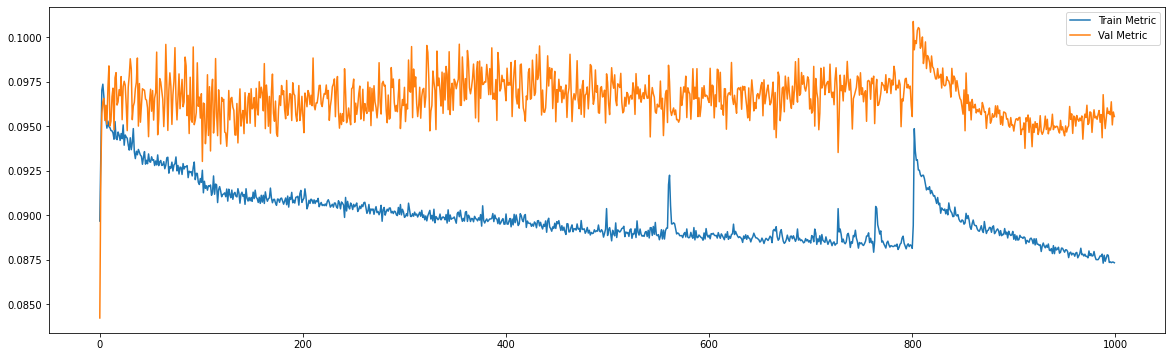

============================model:10===========================


============================model:11===========================


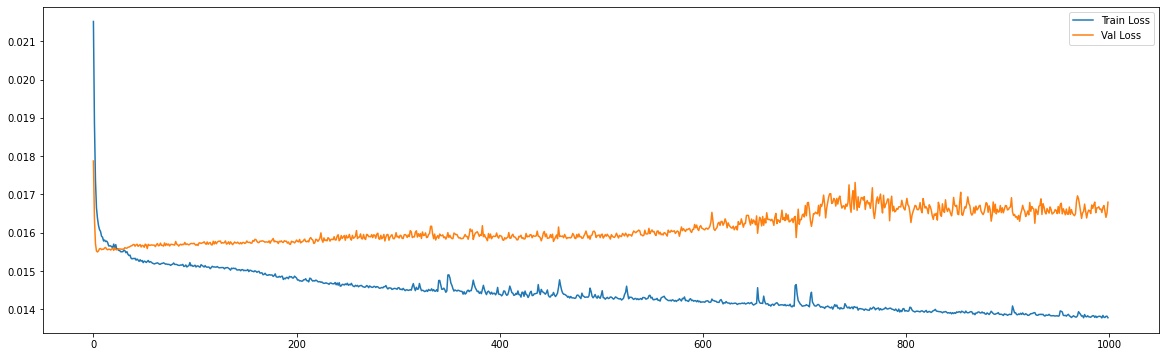

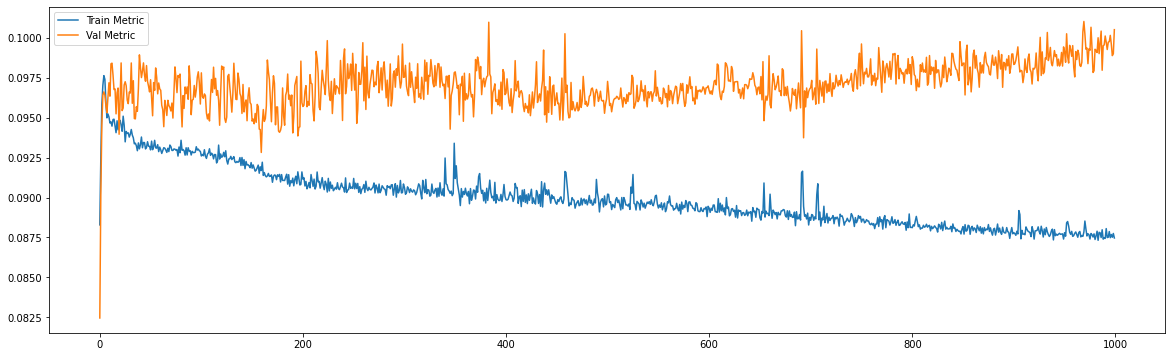

============================model:12===========================


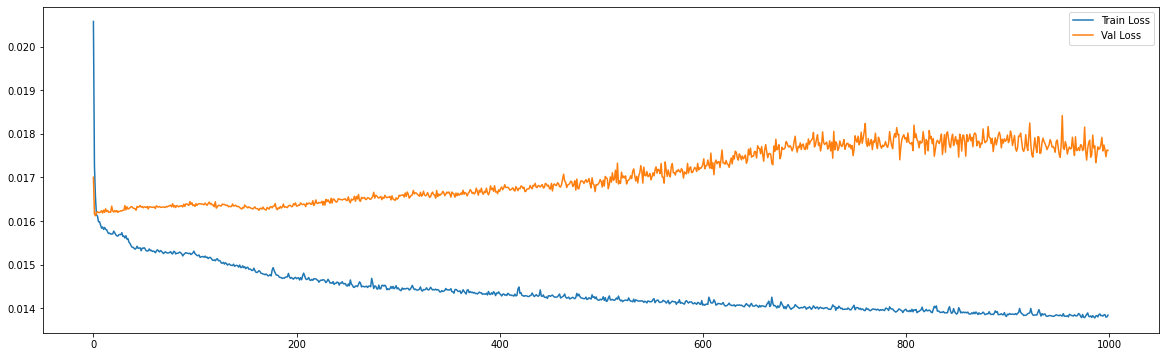

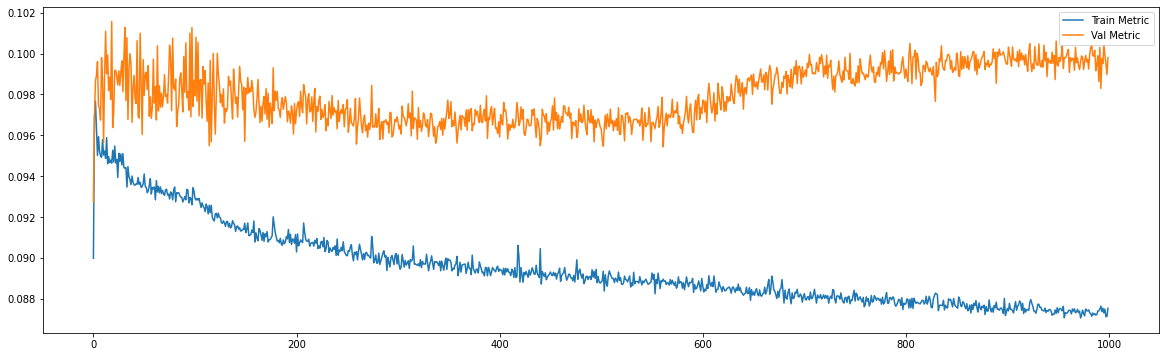

============================model:13===========================


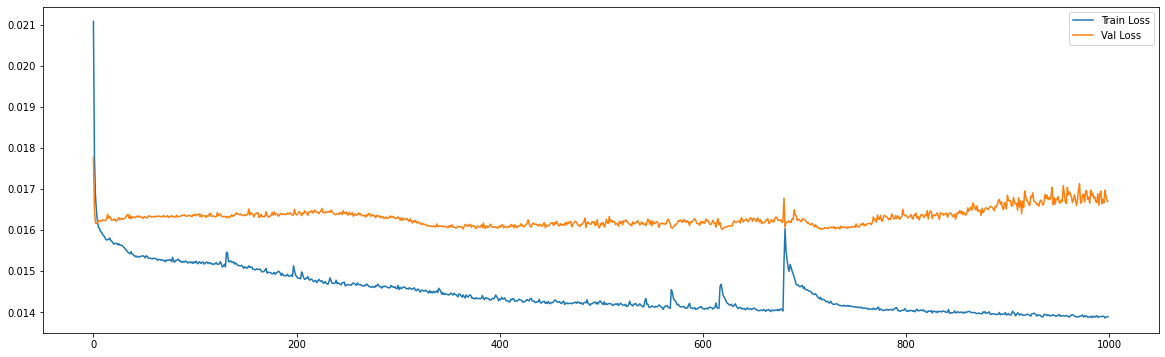

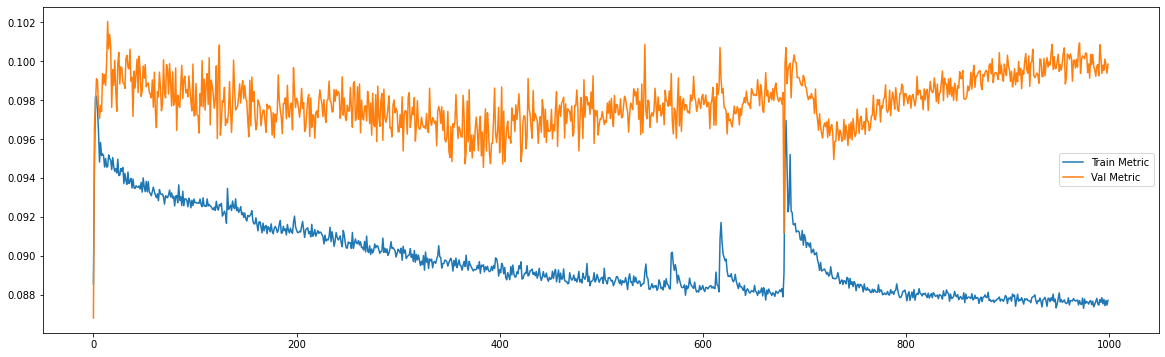

============================model:14===========================


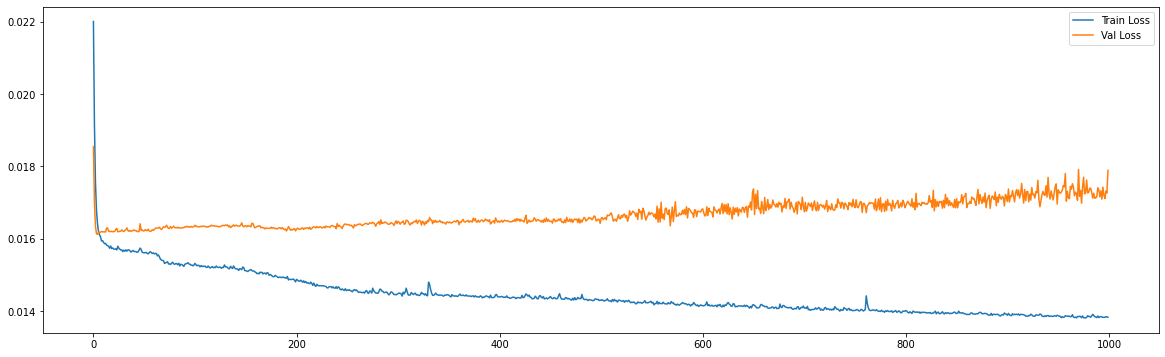

============================model:15===========================


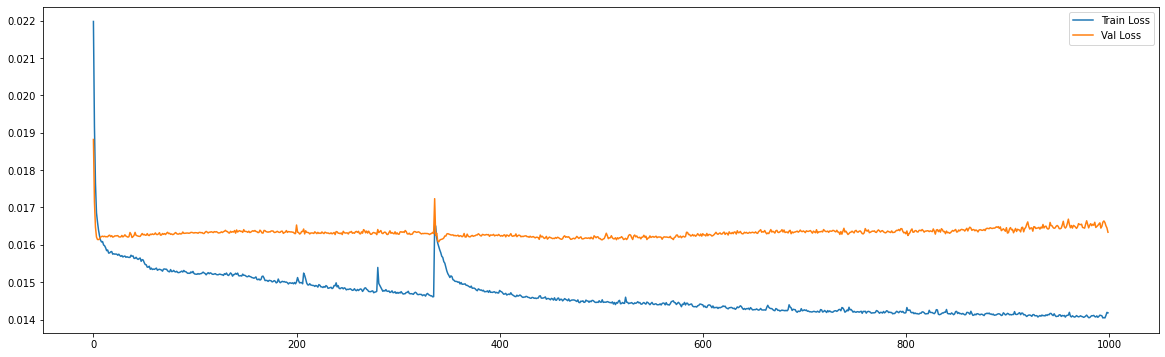

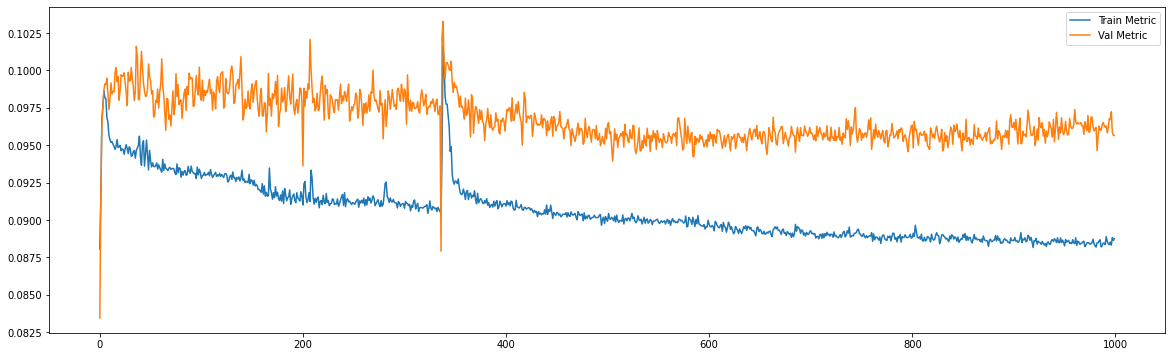

In [0]:
future_steps = 28
n_features = 1

time_steps_list = [50,60,84,100]
bach_list = [50,60,84,100]
models = {}
i=0
for time_steps in time_steps_list:
  for batch in bach_list:
    x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_food_train,df_val = df_food_val,df_test = df_food_test)

    models[i] = {'time_steps': time_steps, 'batch_size':batch}
    models[i]['resumo'] = "'time_steps': {}, 'batch_size':{}".format(time_steps,batch)

    # The LSTM architecture
    models[i] = Sequential()
    models[i].add(LSTM(units=20, return_sequences=False,input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
    models[i].add(Dropout(0.25))
    models[i].add(Dense(units=28))

    #Compiling the LSTM
    adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
    models[i].compile(optimizer = adam, loss = 'mse', metrics=['mae'])

    #Fitting to traning set
    history = models[i].fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 1000, batch_size=batch, verbose = 0)

    print('============================model:{}==========================='.format(i))
    plt.figure(figsize=(20,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Train Loss', 'Val Loss'])

    plt.figure(figsize=(20,6))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.legend(['Train Metric', 'Val Metric'])
    plt.show()

    i+=1

In [0]:
future_steps = 28
n_features = 1
time_steps = 50
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_food_train,df_val = df_food_val,df_test = df_food_test)


# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=20, return_sequences=False,input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))
#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])
#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 5000, batch_size=60, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])
plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

============================model:16===========================


============================model:16===========================


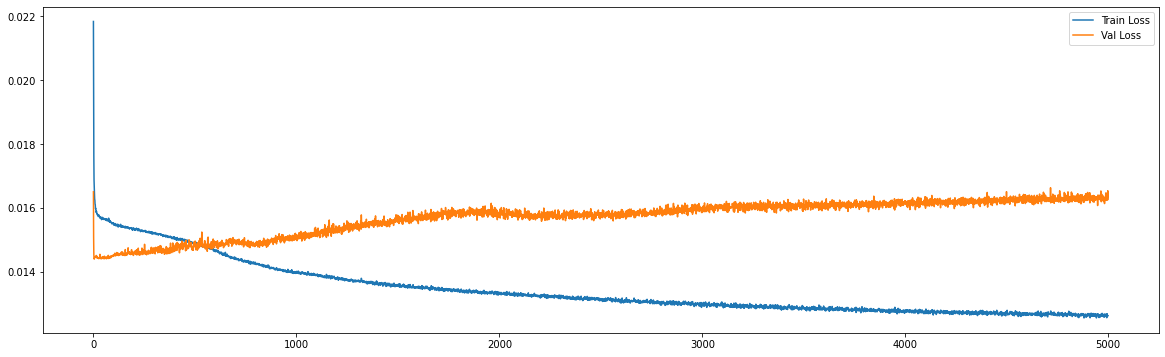

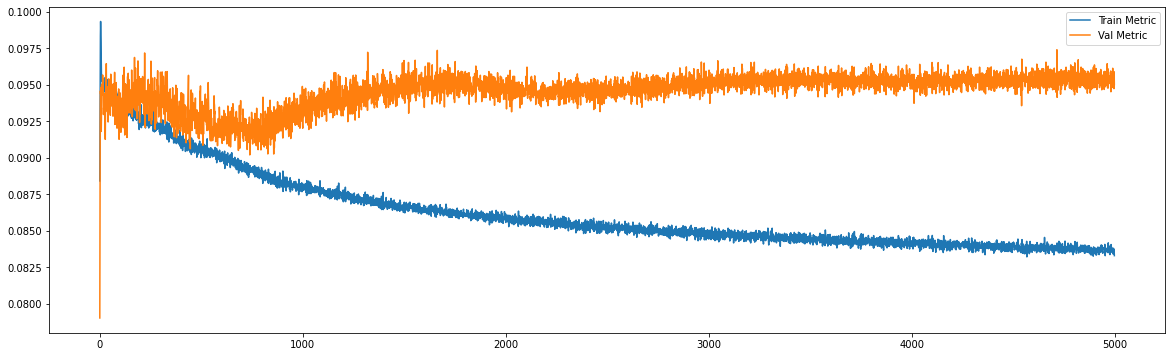

In [0]:
future_steps = 28
n_features = 1
time_steps = 50
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_food_train,df_val = df_food_val,df_test = df_food_test)


# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=20, return_sequences=False,input_shape=(time_steps, n_features))) # return_sequences=True next layer is LSTM
regressor.add(Dropout(0.25))
regressor.add(Dense(units=28))
#Compiling the LSTM
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])
#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 5000, batch_size=100, verbose = 0)

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])
plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()